# Testing data.py

In [1]:
import matplotlib.pyplot as plt

dev_mode = True   # A toggle that is only used for this notebook.
    # If copying code from notebook to python file, remove all the 'if dev_mode' blocks.
    # Any code that's only for testing purposes should be inside such a block.


### Code from the data.py script

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import path   # adds repo to PATH

In [3]:
class DomainMNIST(Dataset):
    '''
    
    '''

    def __init__(self, domains: list[int]) -> None:
        super().__init__()

        # Set attributes
        self.domains = torch.tensor(domains) \
                        if type(domains) != torch.Tensor else \
                        domains.detach().clone()
        self.classes = torch.arange(10)

        ## Predefine attributes for subclasses
        self.data = None
        self.targets = None
        self.domain_labels = None
        self.class_labels = None


    def __len__(self):
        return len(self.targets)


    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        angle = self.domain_labels[index]
        digit = self.class_labels[index]
        
        return image, label, angle, digit



class RotatedMNIST(DomainMNIST):
    '''
    
    '''

    def __init__(self, domains: list[int], train: bool, val_set_size: int=0, seed: int=None) -> None:
        super().__init__(domains)

        # Set attributes
        self.train = train
        self.val_set_size = val_set_size
        self.val = None
        self.root = path.package_directory + "/data"
        if seed != None:
            torch.manual_seed(seed)
        
        # Create dataset
        mnist = datasets.MNIST(root=self.root, train=self.train, download=True, transform=transforms.ToTensor())
        if dev_mode:
            self.mnist = mnist
        self._process_data(mnist)


    def _process_data(self, dataset:Dataset) -> None:
        # Shuffle and normalize the images. normalize: uint8 (0..255) -> float32 (0..1)
        loader = DataLoader(dataset, batch_size=len(dataset.targets), shuffle=True)
        images, class_labels = next(iter(loader))
        images = images.squeeze(1)   # remove the batch dimension
        if dev_mode:
            self.images = images
            self.class_labels = class_labels
            #return images, class_labels

        # Create domain indices
        domain_count = len(self.domains)
        domain_indices = torch.randint_like(class_labels, domain_count)
        if dev_mode:
            self.domain_count = domain_count
            self.domain_indices = domain_indices

        # Create the new domain & class label for the cINN
        domains_sincos = self._deg2sincos(self.domains)
        classes_onehot = torch.eye(10)
        sincos_labels = domains_sincos[domain_indices]
        onehot_labels = classes_onehot[class_labels]
        cinn_labels = torch.cat((sincos_labels, onehot_labels), 1)

        # Rotate the images according to their domain
        images_rotated = torch.zeros_like(images)
        rotations = self.domains[domain_indices]
        for i in range(len(images_rotated)):
            images_rotated[i] = self._rotate(images[i], int(rotations[i]))
        if dev_mode:
            self.domains_sincos = domains_sincos
            self.cinn_labels = cinn_labels
            self.domain_labels = self.domains[domain_indices]  # rotations
            
            #return images, class_labels
        
        
        # Return results
        if self.train and self.val_set_size > 0:
            # Split off a validation set
            cutoff = len(images_rotated) - self.val_set_size   # size of remaining training set
            cut = lambda tensor: self._split(tensor, at=cutoff)
            
            # Create train and validation set
            self.val = DomainMNIST(self.domains)   # create instance for validation set
            self.data,          self.val.data          = cut(images_rotated)
            self.targets,       self.val.targets       = cut(cinn_labels)
            self.domain_labels, self.val.domain_labels = cut(rotations)
            self.class_labels,  self.val.class_labels  = cut(class_labels)
        else:
            # Save train/test set
            self.data          = images_rotated
            self.targets       = cinn_labels
            self.domain_labels = rotations
            self.class_labels  = class_labels
      

    @staticmethod
    def _deg2sincos(degrees:torch.Tensor) -> torch.Tensor:
        return torch.tensor(
            [[np.cos(angle), np.sin(angle)]  for angle in np.deg2rad(degrees)], 
            dtype = torch.float32
        )
    

    @staticmethod
    def _rotate(image:torch.Tensor, degrees:int) -> torch.Tensor:
        to_pil = transforms.ToPILImage()
        to_tensor = transforms.ToTensor()
        
        return to_tensor(transforms.functional.rotate(to_pil(image), degrees))
    

    @staticmethod
    def _split(tensor:torch.Tensor, at:int) -> tuple[torch.Tensor]:
        len_a = at
        len_b = len(tensor) - len_a
        tensor_a, tensor_b = tensor.split([len_a, len_b])
        tensor_a = tensor_a.detach().clone()
        tensor_b = tensor_b.detach().clone()
        
        return tensor_a, tensor_b
        

### Test functions

In [3]:
def show_domain_and_class_distribution(dataset):     
    domains, d_distribution = dataset.domain_labels.unique(return_counts=True)
    print(domains)
    print(d_distribution)
    print(sum(d_distribution))
    print("")
    classes, c_distribution = dataset.class_labels.unique(return_counts=True)
    print(classes)
    print(c_distribution)
    print(sum(c_distribution))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.title("Domains")
    plt.bar([str(int(d)) for d in domains], d_distribution)

    plt.subplot(1, 2, 2)
    plt.title("Classes")
    plt.bar(range(len(classes)), c_distribution)
    plt.xticks(classes)

    plt.show()

In [4]:
def show_image_row(images, titles=None):
    """ 
    code adapted from https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display 
    """
    fig = plt.figure(figsize=(1*len(images), 1))
    for i, image in enumerate(images):
        a = fig.add_subplot(1, len(images), i + 1)
        if titles != None:
            plt.title(titles[i], )
        plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

### Testing validation set creation

In [5]:
# checking if any errors occur during validation set creation
rot = RotatedMNIST([0, 45, 90, 180, 270, 135], train=True, seed=1, val_set_size=1000)

In [6]:
# checking if the validation set was split off as intended
print(rot.val)
print(len(rot), len(rot.val))
print(rot.data.shape, rot.val.data.shape)
print(rot.targets.shape, rot.val.targets.shape)
print(rot.domain_labels.shape, rot.val.domain_labels.shape)
print(rot.class_labels.shape, rot.val.class_labels.shape)


59000 1000
torch.Size([59000, 28, 28]) torch.Size([1000, 28, 28])
torch.Size([59000, 12]) torch.Size([1000, 12])
torch.Size([59000]) torch.Size([1000])
torch.Size([59000]) torch.Size([1000])


In [7]:
# checking if __len__() and __getitem__() behave as expected
for item in rot[len(rot) - 1]:
    print(item.shape, end='  ')
print("")
for item in rot.val[len(rot.val) - 1]:
    print(item.shape, end='  ')

torch.Size([28, 28])  torch.Size([12])  torch.Size([])  torch.Size([])  
torch.Size([28, 28])  torch.Size([12])  torch.Size([])  torch.Size([])  

tensor([  0,  45,  90, 135, 180, 270])
tensor([9668, 9934, 9729, 9966, 9755, 9948])
tensor(59000)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5836, 6636, 5851, 6031, 5745, 5338, 5817, 6153, 5746, 5847])
tensor(59000)


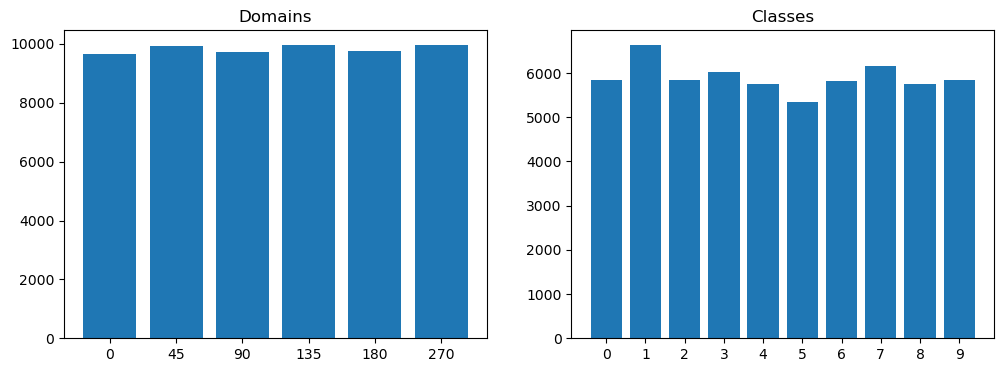

tensor([  0,  45,  90, 135, 180, 270])
tensor([186, 155, 162, 150, 157, 190])
tensor(1000)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 87, 106, 107, 100,  97,  83, 101, 112, 105, 102])
tensor(1000)


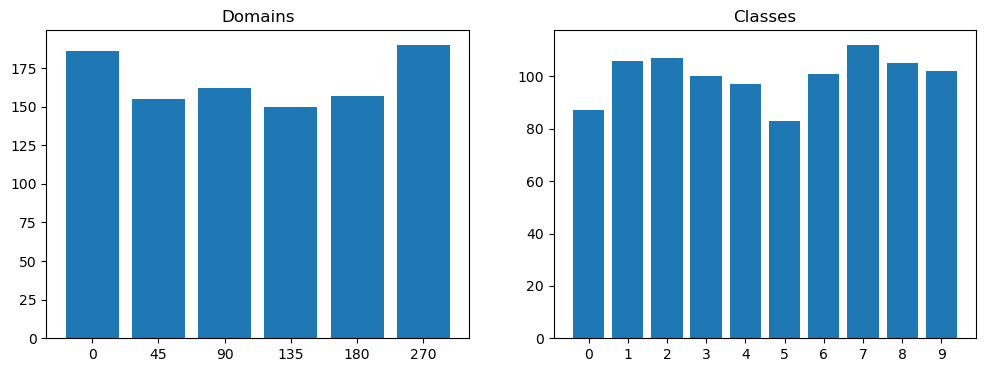

In [8]:
show_domain_and_class_distribution(rot)
show_domain_and_class_distribution(rot.val)

In [9]:
# checking if the training set without validation set is still created.
rot = RotatedMNIST([0, 45, 90, 180, 270, 135], train=True, seed=1)

print(rot.val)
print(len(rot))

None
60000


In [10]:
# testing if torches random_split() for datasets would be a viable alternative
from torch.utils.data import random_split
a, b = random_split(rot, [59000, 1000])

In [11]:
# Result: there is no real split into train and val datasets
# It only works if used via a Dataloader
# Currently, I don't want that restriction, so I keep my custom split.
print(type(a))
print(a.dataset.data.shape)
print(a.dataset[59900][1:])

<class 'torch.utils.data.dataset.Subset'>
torch.Size([60000, 28, 28])
(tensor([-1.8370e-16, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00]), tensor(270), tensor(5))


### Testing _process_data() -> domain distribution

tensor([  0,  45,  90, 135, 180, 270])
tensor([1608, 1694, 1720, 1670, 1630, 1678])
tensor(10000)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])
tensor(10000)


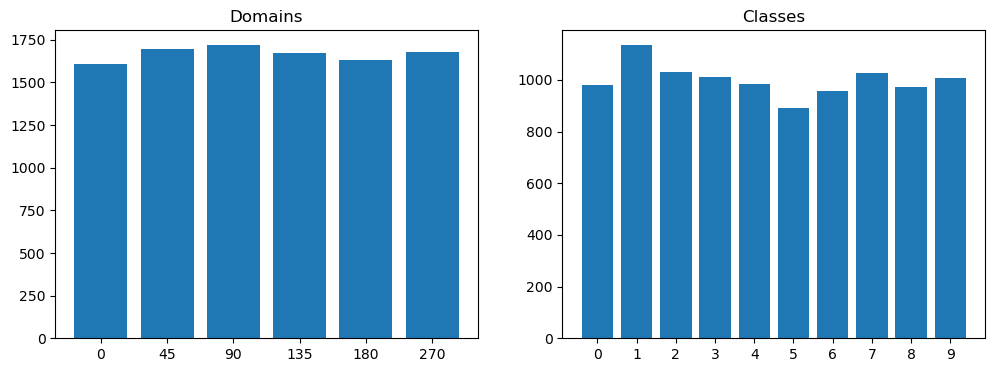

In [12]:
rot = RotatedMNIST([0, 45, 90, 180, 270, 135], train=False, seed=1)

show_domain_and_class_distribution(rot)

### Testing _process_data() -> image rotation

<class 'torch.Tensor'>
torch.Size([10000, 28, 28])
torch.float32

tensor([ 45,  45, 135, 135, 135,   0,  90, 180, 270, 135])
tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2])


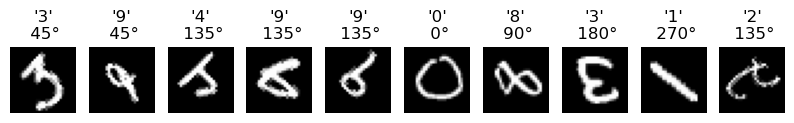

In [13]:
# Testing if the images actually get rotated as expected
rot = RotatedMNIST([0, 45, 90, 180, 270, 135], train=False, seed=1)

print(type(rot.data))
print(rot.data.shape)
print(rot.data.dtype)
print("")

amount = 10
print(rot.domain_labels[:amount])
print(rot.class_labels[:amount])
titles = [f"'{rot.class_labels[i]}'\n {rot.domain_labels[i]}°"  for i in range(amount)]
show_image_row(rot.data[:amount], titles)

### Testing _process_data() -> cINN labels

In [14]:
# Test if creating sincos and onehot codes and combining them to cinn labels works correctly
rot = RotatedMNIST([-10, 15, 30, 180, 720], train=False, seed=1)

print(rot.domains)
print(rot.domains_sincos.T.round(decimals=4))
print("")

print(rot.domain_labels[:8])
print(rot.cinn_labels[:8, :2].T.round(decimals=4))
print("")

print(rot.class_labels[:8])
print(rot.cinn_labels[:8, 2:].T.round(decimals=4))
print("")

print(rot.cinn_labels[:8].T.round(decimals=4))

tensor([-10,  15,  30, 180, 720])
tensor([[ 0.9848,  0.9659,  0.8660, -1.0000,  1.0000],
        [-0.1736,  0.2588,  0.5000,  0.0000, -0.0000]])

tensor([180, 180,  15,  15, 720,  30, 180, 720])
tensor([[-1.0000, -1.0000,  0.9659,  0.9659,  1.0000,  0.8660, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.2588,  0.2588, -0.0000,  0.5000,  0.0000, -0.0000]])

tensor([3, 9, 4, 9, 9, 0, 8, 3])
tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 0.]])

tensor([[-1.0000, -1.0000,  0.9659,  0.9659,  1.0000,  0.8660, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.2588,  0.2588, -0.0000,  0.5000,  0.0000, -0.0000],
        [ 0.0000,  0

### Testing _process_data() -> domain indices

In [15]:
# Test if seed still applies to domain_label sampling
rot_sets = [
    RotatedMNIST([-10, 15, 30, 180, 720], train=False),
    RotatedMNIST([-10, 15, 30, 180, 720], train=False),
    RotatedMNIST([-10, 15, 30, 180, 720], train=False, seed=1),
    RotatedMNIST([-10, 15, 30, 180, 720], train=False, seed=1),
]

for rot in rot_sets:
    print(rot.domain_indices[:10])
    print("")
    

tensor([3, 4, 1, 3, 1, 3, 3, 4, 0, 1])

tensor([2, 1, 2, 1, 1, 2, 3, 4, 1, 1])

tensor([3, 3, 1, 1, 4, 2, 3, 4, 1, 3])

tensor([3, 3, 1, 1, 4, 2, 3, 4, 1, 3])



In [16]:
# Test if domain_count and domain_labels are produced correctly
rot_sets = [
    RotatedMNIST([0, 15, 30], train=False),
    RotatedMNIST([0], train=False),
    RotatedMNIST([-10, 15, 30, 180, 720], train=False),
]

for rot in rot_sets:
    print(rot.domain_count)
    print(rot.domain_labels.shape)
    print(rot.domain_labels[:10])
    print("")

3
torch.Size([10000])
tensor([30, 15,  0, 30, 30,  0,  0, 15,  0, 30])

1
torch.Size([10000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

5
torch.Size([10000])
tensor([ 15,  15,  30, -10,  30, -10,  15,  15, 720, 180])



### Testing _process_data() -> dataloader

In [17]:
# Test if the dataloader works for the train set too
rot = RotatedMNIST([0, 15, 30], train=True)

data = rot.images
print(type(data))
print(data.shape)
print(data.dtype)
print(data.min(), data.max())
print("")

targets = rot.class_labels
print(type(targets))
print(targets.shape)
print(targets.dtype)
print(targets.min(), targets.max())
print("")

<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.float32
tensor(0.) tensor(1.)

<class 'torch.Tensor'>
torch.Size([60000])
torch.int64
tensor(0) tensor(9)



In [18]:
# Test if the dataloader does what it should
rot = RotatedMNIST([0, 15, 30], train=False)

data = rot.images
print(type(data))
print(data.shape)
print(data.dtype)
print(data.min(), data.max())
print("")

targets = rot.class_labels
print(type(targets))
print(targets.shape)
print(targets.dtype)
print(targets.min(), targets.max())
print("")

<class 'torch.Tensor'>
torch.Size([10000, 28, 28])
torch.float32
tensor(0.) tensor(1.)

<class 'torch.Tensor'>
torch.Size([10000])
torch.int64
tensor(0) tensor(9)



In [19]:
# Test if manual seeds work
rot_set = [
    RotatedMNIST([0, 15, 30], train=False),
    RotatedMNIST([0, 15, 30], train=False),
    RotatedMNIST([0, 15, 30], train=False, seed=1),
    RotatedMNIST([0, 15, 30], train=False, seed=1),
]

for rot in rot_set:
    print(rot.mnist.targets[:10])
    print(rot.class_labels[:10])
    print("")

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
tensor([7, 8, 6, 2, 7, 1, 1, 0, 9, 5])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
tensor([2, 4, 4, 2, 4, 2, 6, 4, 4, 6])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2])



### Testing init() -> mnist dateset

In [20]:
# Test if train=False loads the mnist test set
rot = RotatedMNIST([0, 15, 30], train=False)

data = rot.mnist.data
print(type(data))
print(data.shape)
print(data.dtype)
print(data.min(), data.max())
print("")

targets = rot.mnist.targets
print(type(targets))
print(targets.shape)
print(targets.dtype)
print(targets.min(), targets.max())
print("")

<class 'torch.Tensor'>
torch.Size([10000, 28, 28])
torch.uint8
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)

<class 'torch.Tensor'>
torch.Size([10000])
torch.int64
tensor(0) tensor(9)



In [21]:
# Test if the mnist dataset is loaded correctly
rot = RotatedMNIST([0, 15, 30], train=True)

print(rot.mnist.classes)
print("")

data = rot.mnist.data
print(type(data))
print(data.shape)
print(data.dtype)
print(data.min(), data.max())
print("")

targets = rot.mnist.targets
print(type(targets))
print(targets.shape)
print(targets.dtype)
print(targets.min(), targets.max())
print("")

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.uint8
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)

<class 'torch.Tensor'>
torch.Size([60000])
torch.int64
tensor(0) tensor(9)



In [4]:
# Test if the basic attributes work
rot = RotatedMNIST([0, 15, 30], train=False)

print(rot.domains)
print(rot.classes)
print(rot.train)
print(rot.val_set_size)
print(rot.root)

tensor([ 0, 15, 30])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
False
0
/home/birk/Documents/Programmieren/Bachelor Thesis/Own Code/Rotated-cINN/rotated_cinn/data
